In [1]:
import re
import pandas as pd
import datetime as dt
from psaw import PushshiftAPI

api = PushshiftAPI()

## Note!! Here I am searching for Fitbit, just to identify subreddits to search so they should all mention Fitbit. Not to be used for lifts

In [2]:
gen = api.search_comments(after=int(dt.datetime(2019, 10, 1).timestamp()),
                             before = int(dt.datetime(2019, 11, 30).timestamp()),
                             q = "Fitbit",
                             limit = 10000)


df_fitbit = pd.DataFrame([obj.d_ for obj in gen])

In [3]:
df_fitbit.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'awarders', 'body',
       'collapsed_because_crowd_control', 'created_utc', 'gildings', 'id',
       'is_submitter', 'link_id', 'locked', 'no_follow', 'parent_id',
       'permalink', 'retrieved_on', 'score', 'send_replies', 'steward_reports',
       'stickied', 'subreddit', 'subreddit_id', 'total_awards_received',
       'created', 'distinguished', 'author_cakeday', 'edited'],
      dtype='object')

In [11]:
len(df_fitbit)

8942

In [4]:
df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True).value_counts()

False    7328
True     1614
Name: body, dtype: int64

In [5]:
df_fitbit['date'] = pd.to_datetime(df_fitbit['created_utc'],unit='s')

In [6]:
df_fitbit['google_mention'] = df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True)

In [7]:
subset = df_fitbit[['date', 'google_mention']]

In [8]:
subset['day'] = subset['date'].dt.date

c:\users\chenson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

c:\users\chenson\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


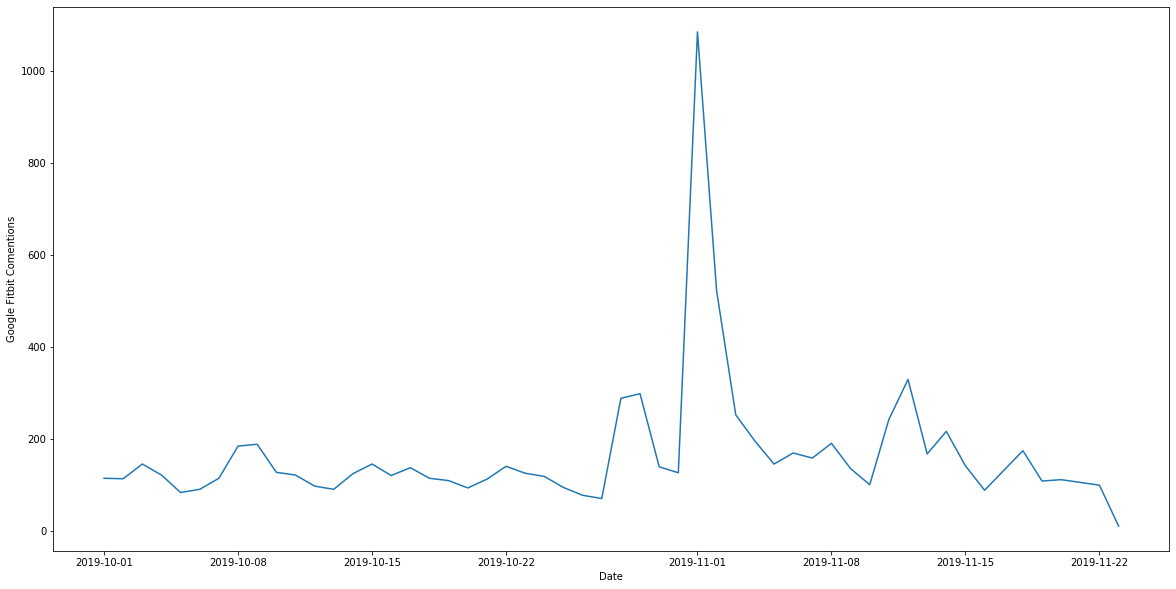

In [10]:
plt.figure(figsize=(20,10))
plt.plot(subset.groupby('day')['google_mention'].agg('count'))
plt.xlabel('Date')
plt.ylabel('Google Fitbit Comentions')
plt.show()

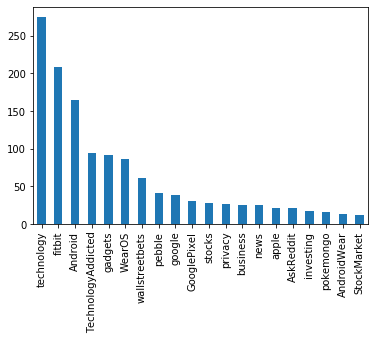

In [30]:
#subreddits with comentions
df_fitbit[df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True)].subreddit.value_counts().iloc[:20].plot.bar()

## Let's try scaping subreddits with high co-mentions

In [112]:
mention_subs = df_fitbit[df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True)].subreddit.value_counts().iloc[:15].index

In [113]:
%%time
df_list = []

for sub in mention_subs:

    gen = api.search_comments(after=int(dt.datetime(2019, 10, 22).timestamp()),
                              before = int(dt.datetime(2019, 11, 22).timestamp()),
                              limit = 10000,
                              subreddit = sub)


    df = pd.DataFrame([obj.d_ for obj in gen])  
    df_list.append(df)

Wall time: 4min


In [114]:
[len(df) for df in df_list]

[10000,
 3028,
 10000,
 10000,
 10000,
 5078,
 10000,
 2810,
 7078,
 10000,
 10000,
 10000,
 10000,
 10000,
 10000]

In [116]:
df = pd.concat(df_list)

c:\users\chenson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [117]:
df['date'] = pd.to_datetime(df['created_utc'],unit='s').dt.date

In [123]:
df.columns

Index(['all_awardings', 'associated_award', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'awarders', 'body',
       'collapsed_because_crowd_control', 'created', 'created_utc',
       'distinguished', 'edited', 'gildings', 'id', 'is_submitter', 'link_id',
       'locked', 'no_follow', 'parent_id', 'permalink', 'retrieved_on',
       'score', 'send_replies', 'steward_reports', 'stickied', 'subreddit',
       'subreddit_id', 'total_awards_received', 'date'],
      dtype='object')

In [124]:
#google mentions
len(df[df['body'].str.contains('google', flags=re.IGNORECASE, regex=True)])

8160

In [126]:
#about 6% comentions
len(df[df['body'].str.contains('google', flags=re.IGNORECASE, regex=True)])/len(df)

0.06375298842133224

In [129]:
subset = df[df['body'].str.contains('google', flags=re.IGNORECASE, regex=True)]
subset = subset[['date', 'subreddit']]

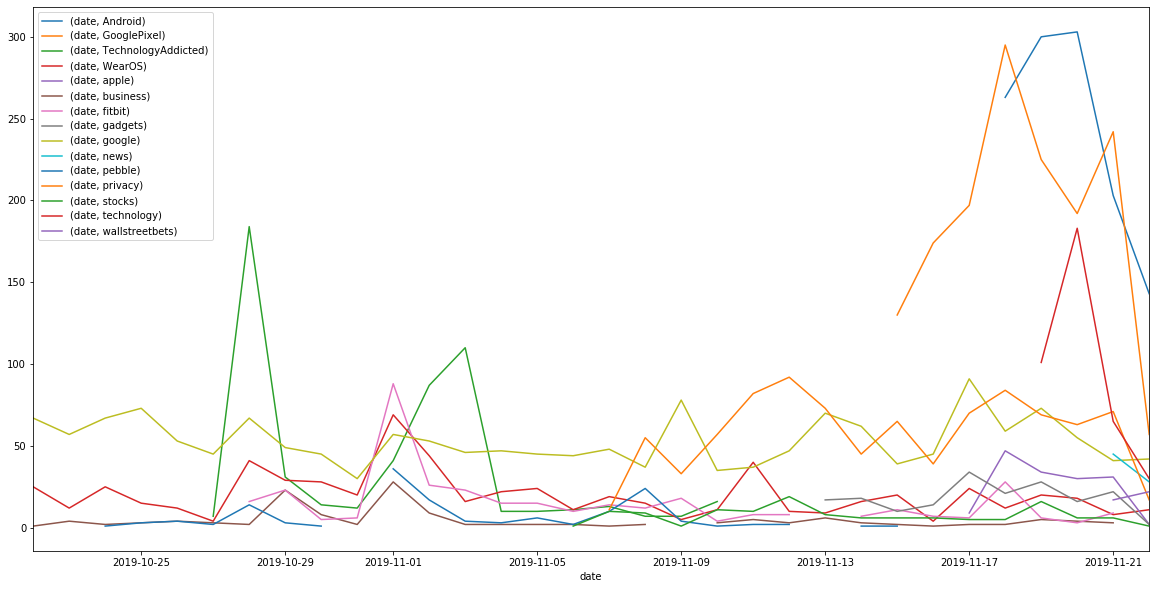

In [132]:
subset.groupby(['date', 'subreddit'])[['date']].agg('count').unstack().plot(figsize=(20,10))
plt.legend()
plt.show()